In [7]:
import tensorflow as tf
from keras.datasets import mnist
from time import time 
import foolbox as fb
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
from timeit import default_timer as timer

import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

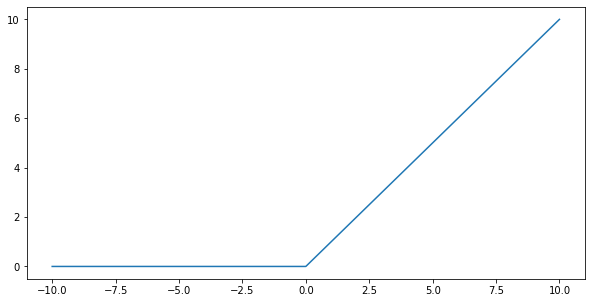

In [2]:

# https://tcoil.info/activation-functions-sigmoid-tanh-relu/
x = np.linspace(-10, 10, 1000)
y = np.maximum(0, x)

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.show()



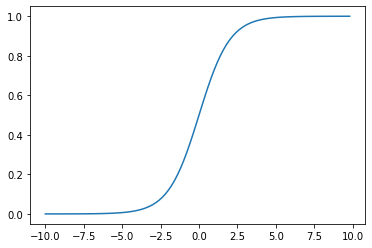

In [5]:
# https://squall0032.tumblr.com/post/77300791096/plotting-a-sigmoid-function-using
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10, 10, 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

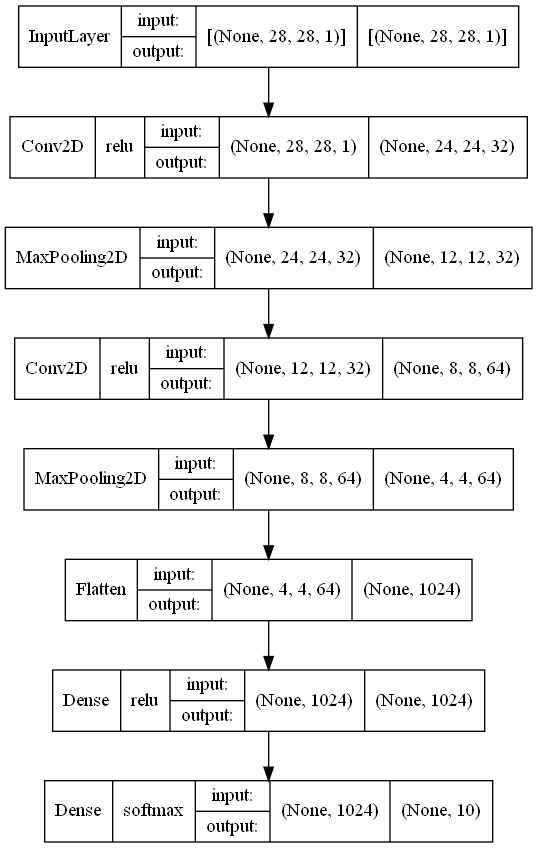

In [6]:
model=load_model("models/vanilla_model")
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


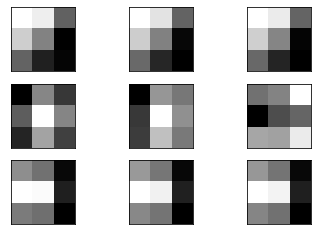

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [8]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

# cannot easily visualize filters lower down
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 3, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()



# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

Epoch 1/20
235/235 [==============================] - 11s 11ms/step - loss: 1.0849 - accuracy: 0.8352 - val_loss: 0.0965 - val_accuracy: 0.9720
Epoch 2/20
235/235 [==============================] - 2s 8ms/step - loss: 0.1111 - accuracy: 0.9671 - val_loss: 0.0607 - val_accuracy: 0.9802
Epoch 3/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0730 - accuracy: 0.9782 - val_loss: 0.0505 - val_accuracy: 0.9842
Epoch 4/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.0472 - val_accuracy: 0.9868
Epoch 5/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0484 - accuracy: 0.9854 - val_loss: 0.0421 - val_accuracy: 0.9867
Epoch 6/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0383 - accuracy: 0.9876 - val_loss: 0.0373 - val_accuracy: 0.9883
Epoch 7/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0357 - accuracy: 0.9887 - val_loss: 0.0424 - val_accuracy: 0.9866
Epoc

<ipython-input-9-411135dc1976>:61: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


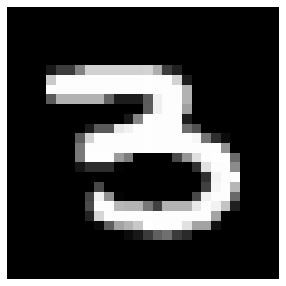

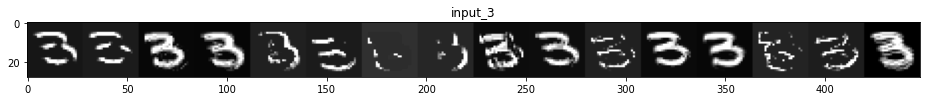

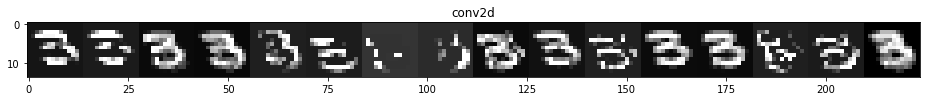

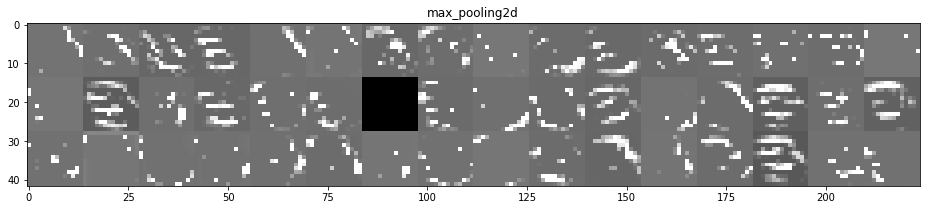

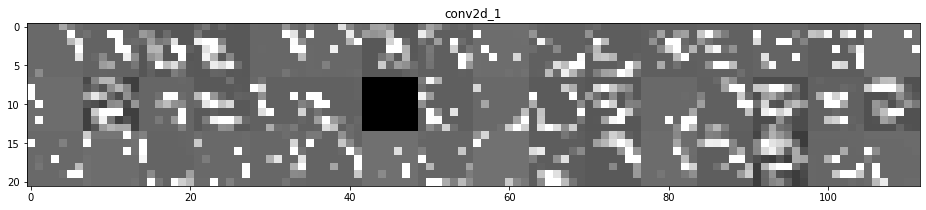

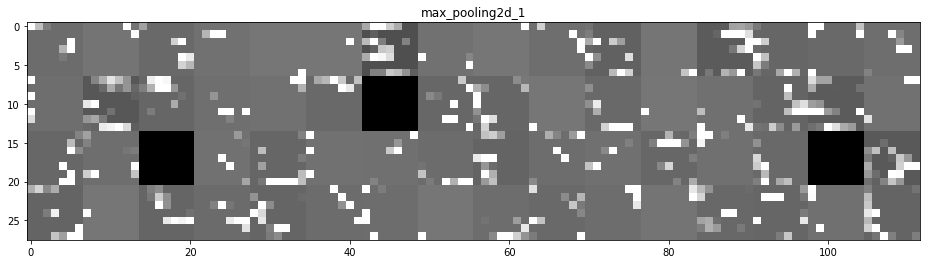

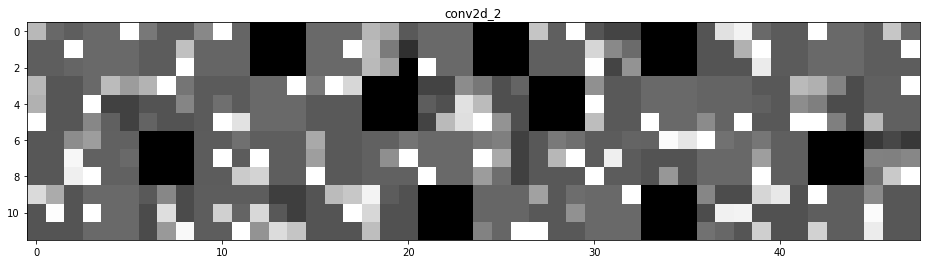

In [9]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

inputs = Input(shape=(28,28,1))
x = Conv2D(24,kernel_size=(3,3),padding='same',activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(48, (3, 3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(10,activation="softmax")(x)

model = Model(inputs,output)

model.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])
    


(x_train, y_train), (x_test, y_test) = mnist.load_data()

epochs = 20
batch_size=256


history = model.fit(x_train,to_categorical(y_train),
         epochs=epochs,
         batch_size=batch_size,
         validation_data=(x_test,to_categorical(y_test)))
         
layer_outputs = [layer.output for layer in model.layers[1:7]]
# activation_model = Model(inputs=model.input,outputs=layer_outputs)


img = x_test[51].reshape(1,28,28,1)
fig = plt.figure(figsize=(5,5))
plt.imshow(img[0,:,:,0],cmap="gray")
plt.axis('off')

activation_model = Model(inputs=model.input,outputs=layer_outputs)
activations = activation_model.predict(img)

layer_names = []
for layer in model.layers[0:7]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')